# Joseph Breneman, Characterizing a CCD (project code and calculations).

In [118]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from astropy.table import Table, Column
import sys
from scipy.optimize import curve_fit

### We're going to import an Image to verify functionality

In [119]:
image = fits.getdata('ourproject/slitview.00000359.FLAT.FIT').astype(np.int32)
print(image.shape)
print('')
print(image)

(495, 657)

[[  344   381   441 ...   477   388   355]
 [  424   522   501 ...   768   666   609]
 [  533   498   474 ...   709   603   653]
 ...
 [ 7748  7400  7926 ... 10730  9884 10014]
 [ 7847  7366  8059 ... 10473 10303 10120]
 [ 7469  7242  7997 ... 10659  9493 10019]]


### Now we're going to import the images we plan to use for calculating the gain.

In [120]:
flat1 = fits.getdata('ourproject/slitview.00000359.FLAT.FIT').astype(np.int32)
flat2 = fits.getdata('ourproject/slitview.00000358.FLAT.FIT').astype(np.int32)
bias1 = fits.getdata('ourproject/slitview.00000353.BIAS.FIT').astype(np.int32)
bias2 = fits.getdata('ourproject/slitview.00000354.BIAS.FIT').astype(np.int32)

## Calculating the gain using equation 3 from the assignment.

In [121]:
mean_f1 = np.mean(flat1)
print(mean_f1)

mean_f2 = np.mean(flat2)
print(mean_f2)

mean_b1 = np.mean(bias1)
print(mean_b1)

mean_b2 = np.mean(bias2)
print(mean_b2)

sigma_f1f2 = np.std(flat1-flat2)
print(sigma_f1f2)

sigma_b1b2 = np.std(bias1-bias2)
print(sigma_f1f2)

gain = ((mean_f1+mean_f2)-(mean_b1+mean_b2))/((sigma_f1f2)**2-(sigma_b1b2)**2)
gain1=1/gain
print(gain)

17669.282514644157
17692.17737496733
107.69197915225313
108.63560413880049
284.7220363296057
284.7220363296057
0.44857742740418655


### and the read noise using equation 4 from the assignment.

In [122]:
read_noise = (gain*sigma_b1b2)/(np.sqrt(2))
read_noise_ADUs = read_noise/gain1
print(read_noise_ADUs)
print(read_noise)

7.418868199802995
16.538656977758027


### Next we will make sub-sections of the images, separated into columns and rows, and evaluate the means, standard deviations, gains, and read noise of the sub-sections.

In [123]:
row0 = 100
row1 = 200
colm0 = 200
colm1 = 300

rflat1 = flat1[row0:row1, colm0:colm1]
rflat2 = flat2[row0:row1, colm0:colm1]
rbias1 = bias1[row0:row1, colm0:colm1]
rbias2 = bias2[row0:row1, colm0:colm1]

sub_mean_f1 = np.mean(rflat1)
print(sub_mean_f1)

sub_mean_f2 = np.mean(rflat2)
print(sub_mean_f2)

sub_mean_b1 = np.mean(rbias1)
print(sub_mean_b1)

sub_mean_b2 = np.mean(rbias2)
print(sub_mean_b2)

sub_sigma_f1f2 = np.std(rflat1-rflat2)
print(sub_sigma_f1f2)

sub_sigma_b1b2 = np.std(rbias1-rbias2)
print(sub_sigma_b1b2)

sub_gain = ((sub_mean_f1+sub_mean_f2)-(sub_mean_b1+sub_mean_b2))/((sub_sigma_f1f2)**2-(sub_sigma_b1b2)**2)
print(sub_gain)

sub_read_noise = (sub_gain*sub_sigma_b1b2)/(np.sqrt(2))
print(sub_read_noise)

21118.5921
21149.7398
112.2998
111.3137
311.0034985087949
52.47023257800559
0.4474267923869122
16.600454473635402


In [124]:
print(
"""
The gain ({0:.2f}) and the read noise ({1:.2f}) are very close to the specification values given by the manufacturer.
Specifications: Gain is 2.3 electrons/ADU and the Read Noise is 15 electrons*RMS.
""".format(gain1, read_noise)
)


The gain (2.23) and the read noise (16.54) are very close to the specification values given by the manufacturer.
Specifications: Gain is 2.3 electrons/ADU and the Read Noise is 15 electrons*RMS.



### Now I'm gonna get fancy and show off my copy/paste skills.

In [125]:
def calculate_gain(flat_1, flat_2, bias_1, bias_2):
    """
    Calculate detector gain given two flat frames and two bias frames.
    
    Parameters
    ----------
    flat_1, flat_2 : numpy.array_like
        The flat frames
    bias_1, bias_2 : numpy.array_like
        The bias frames
        
    Returns
    -------
    gain : float
        The detector gain
    """
    # This is Equation 3 from the assignment
    numerator = (np.mean(flat_1) + np.mean(flat_2)) - (np.mean(bias_1) + np.mean(bias_2))
    denominator = np.std((flat_1 - flat_2)) ** 2 - np.std((bias_1 - bias_2)) ** 2
    gain = denominator / numerator
    
    return gain

In [126]:
flat_1 = fits.getdata('ourproject/slitview.00000359.FLAT.FIT').astype(np.int32)
flat_2 = fits.getdata('ourproject/slitview.00000358.FLAT.FIT').astype(np.int32)
bias_1 = fits.getdata('ourproject/slitview.00000353.BIAS.FIT').astype(np.int32)
bias_2 = fits.getdata('ourproject/slitview.00000354.BIAS.FIT').astype(np.int32)

In [127]:
row_bins = np.linspace(0, flat_1.shape[0], 5).astype(int)
print(row_bins)
col_bins = np.linspace(0, flat_1.shape[1], 10).astype(int)
print(col_bins)

[  0 123 247 371 495]
[  0  73 146 219 292 365 438 511 584 657]


In [128]:
# This is an array to store the gain in each subregion.
gain_map = np.zeros((len(row_bins) - 1, len(col_bins - 1)))

# This nested for loop goes through each subregion.
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_slice = slice(row_bins[ii], row_bins[ii + 1])
        col_slice = slice(col_bins[jj], col_bins[jj + 1])
        
        # The `local_gain` is the gain in the subregion
        local_gain = calculate_gain(flat_1[row_slice, col_slice], flat_2[row_slice, col_slice],
                                    bias_1[row_slice, col_slice], bias_2[row_slice, col_slice])
        
        # Store the local gain in the `gain_map`
        gain_map[ii, jj] = local_gain

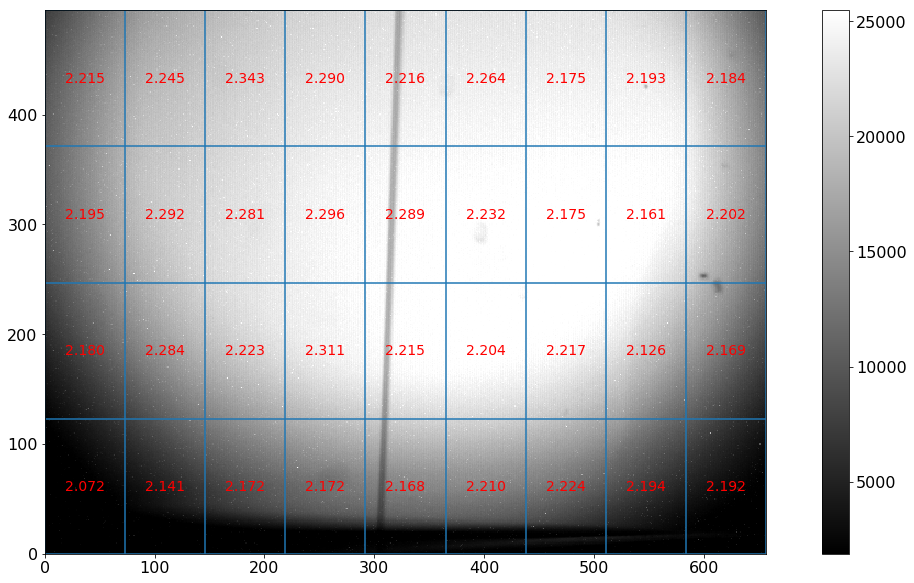

In [129]:
plt.figure(figsize=(20, 10))

# Use the imshow function to plot one of the flat images for reference.
plt.imshow(flat_1, vmin=np.percentile(flat_1, 5), vmax=np.percentile(flat_1, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')


# Plot the boundaries of the subregions
for row in row_bins:
    plt.axhline(row)
for col in col_bins:
    plt.axvline(col)

# Print the local gain value in each subregion
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        plt.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='r')

plt.xlim(0, col_bins[-1])
plt.ylim(0, row_bins[-1])

# Add a colorbar
plt.colorbar()
plt.show()

## We are now going to look at linearity of the CCD.

In [130]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob

### We are first going to look at the header to find the exposure time

In [131]:
hdu = fits.open('ourproject1/Pencil105.FLAT.FIT')
header = hdu[0].header
print(header)

SIMPLE  =                    T/CCDSOFT-SOFTWARE BISQUE 2                        BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                  657                                                  NAXIS2  =                  495                                                  BSCALE  = +1.000000000000E+000                                                  BZERO   = +3.276800000000E+004                                                  BIAS    =                  100                                                  ORIGIN  = 'Origin              '                                                TELESCOP= '80.0 35.0           '                                                FOCALLEN= +8.000000000000E+001                                                  APERTURE= +3.500000000000E+001                                                  OBSERVER= 'Observer            '        

 [astropy.io.fits.verify]


### Now that we know the exposure time is stored in the header under the category 'EXPOSURE' we can extract only that information that we want to use.

In [132]:
print(header['EXPOSURE']*(u.s))

105.0 s


### Next we will make a list out of our fit files.

In [133]:
flat_list = glob.glob('ourproject1/*FLAT.FIT')
print(flat_list)

['ourproject1/Pencil105.FLAT.FIT', 'ourproject1/Pencil75.FLAT.FIT', 'ourproject1/Pencil90.FLAT.FIT', 'ourproject1/Pencil15.FLAT.FIT', 'ourproject1/Pencil0.625.FLAT.FIT', 'ourproject1/Pencil1.25.FLAT.FIT', 'ourproject1/Pencil65.FLAT.FIT', 'ourproject1/Pencil0.3125.FLAT.FIT', 'ourproject1/Pencil0.16.FLAT.FIT', 'ourproject1/Pencil85.FLAT.FIT', 'ourproject1/Pencil5.FLAT.FIT', 'ourproject1/Pencil55.FLAT.FIT', 'ourproject1/Pencil35.FLAT.FIT', 'ourproject1/Pencil95.FLAT.FIT', 'ourproject1/Pencil45.FLAT.FIT', 'ourproject1/Pencil2.5.FLAT.FIT', 'ourproject1/Pencil25.FLAT.FIT']


### Now we will extract the information we need from the header to make a plot so we can find the Linearity range of the CCD

In [134]:
# These are empty lists (arrays) to store the exposure times and mean counts
exp_times = []
means = []

for filename in flat_list:
    # Open the FITS file
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['EXPOSURE']
    print('Exposure time {} sec'.format(exptime))
    
    # This will append the exposure time for each image to the array
    exp_times.append(exptime)
    
    # Same for mean counts
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
exp_times = np.array(exp_times)
means = np.array(means)

# Sort by exposure time so the plot looks correct
time_sort = np.argsort(exp_times)
exp_times = exp_times[time_sort]
means = means[time_sort]

Exposure time 105.0 sec
Mean counts: 34076.27

Exposure time 75.0 sec
Mean counts: 31235.74

Exposure time 90.0 sec
Mean counts: 32542.03

Exposure time 15.0 sec
Mean counts: 6514.27

Exposure time 0.63 sec
Mean counts: 402.87

Exposure time 1.25 sec
Mean counts: 698.58

Exposure time 65.0 sec
Mean counts: 27911.69

Exposure time 0.31 sec
Mean counts: 260.67

Exposure time 0.16 sec
Mean counts: 185.59

Exposure time 85.0 sec
Mean counts: 33109.37

Exposure time 5.0 sec
Mean counts: 1912.06

Exposure time 55.0 sec
Mean counts: 23804.44

Exposure time 35.0 sec
Mean counts: 15383.94

Exposure time 95.0 sec
Mean counts: 32454.10

Exposure time 45.0 sec
Mean counts: 19442.49

Exposure time 2.5 sec
Mean counts: 1255.83

Exposure time 25.0 sec
Mean counts: 11222.69



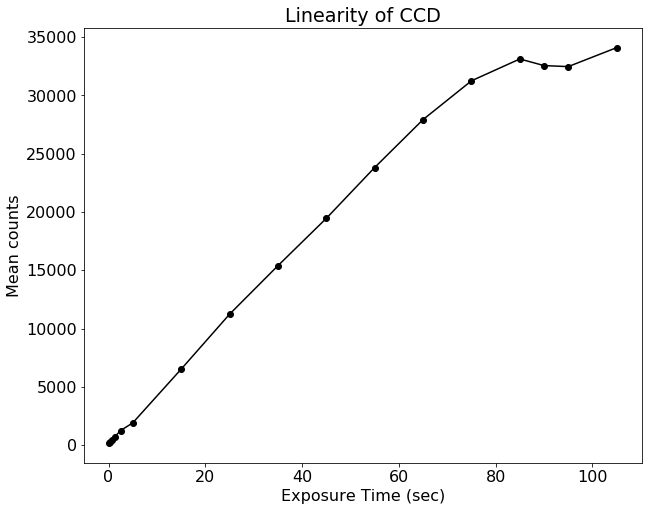

In [158]:
plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16

plt.title('Linearity of CCD')
plt.plot(exp_times, means, '-ko')
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Mean counts')
plt.show()

### It would apper that linearity is lost around 31000 counts.

In [170]:
CCD_spec_FW_e=100000
CCD_spec_FW_ADU=CCD_spec_FW/gain1
AD_spec_ADU=(2)**(16)
AD_spec_e=gain1*AD_spec_ADU

print(CCD_spec_FW_e)
print(CCD_spec_FW_ADU)
print(AD_spec_e)
print(AD_spec_ADU)

100000
44857.74274041866
146097.409268321
65536


In [178]:
name=['CCD FW spec (e)', 'CCD FW spec (ADU)', 'A/D spec (e)', 'A/D spec (ADU)']
spec=[CCD_spec_FW_e, CCD_spec_FW_ADU, AD_spec_e, AD_spec_ADU]
sp = Table([name, spec], names=('Saturation (units)', 'Specification'))
sp

Saturation (units),Specification
str17,float64
CCD FW spec (e),100000.0
CCD FW spec (ADU),44857.74274041866
A/D spec (e),146097.409268321
A/D spec (ADU),65536.0


In [224]:
ST9_CCD_spec_FW_e=150000
ST9_CCD_spec_FW_ADU=ST9_CCD_spec_FW_e/1.6
ST9_AD_spec_ADU=(2)**(16)
ST9_AD_spec_e=1.6*ST9_AD_spec_ADU

print(ST9_CCD_spec_FW_e)
print(ST9_CCD_spec_FW_ADU)
print(ST9_AD_spec_e)
print(ST9_AD_spec_ADU)

150000
93750.0
104857.6
65536


In [225]:
name1=['ST9 CCD FW spec (e)', 'ST9 CCD FW spec (ADU)', 'ST9 A/D spec (e)', 'ST9 A/D spec (ADU)']
spec1=[ST9_CCD_spec_FW_e, ST9_CCD_spec_FW_ADU, ST9_AD_spec_e, ST9_AD_spec_ADU]
st = Table([name1, spec1], names=('ST9 Saturation (units)', 'ST9 Specification'))
st

ST9 Saturation (units),ST9 Specification
str21,float64
ST9 CCD FW spec (e),150000.0
ST9 CCD FW spec (ADU),93750.0
ST9 A/D spec (e),104857.6
ST9 A/D spec (ADU),65536.0


## Now would be a good time to make a few tables of the data we have extracted from the image headers.

In [226]:
t = Table([exp_times, means], names=('Exposure Time (s)', 'Mean Counts'))
t

Exposure Time (s),Mean Counts
float64,float64
0.16,185.59160247836047
0.31,260.6681272389035
0.63,402.8713958458251
1.25,698.5824177851575
2.5,1255.8344049321217
5.0,1912.061371707947
15.0,6514.270888489154
25.0,11222.694362191165
35.0,15383.940599295851


In [138]:
flat_list_flat = glob.glob('ourproject/*FLAT.FIT')
print(flat_list_flat)

['ourproject/slitview.00000358.FLAT.FIT', 'ourproject/slitview.00000359.FLAT.FIT', 'ourproject/slitview.00000357.FLAT.FIT']


In [139]:
flat_list_bias = glob.glob('ourproject/*BIAS.FIT')
print(flat_list_bias)

['ourproject/slitview.00000352.BIAS.FIT', 'ourproject/slitview.00000353.BIAS.FIT', 'ourproject/slitview.00000355.BIAS.FIT', 'ourproject/slitview.00000354.BIAS.FIT', 'ourproject/slitview.00000356.BIAS.FIT']


In [140]:
exp_times_flat = []
means_flat = []

for filename in flat_list_flat:
    # Open the FITS file
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['EXPOSURE']
    print('Exposure time {} sec'.format(exptime))
    
    # This will append the exposure time for each image to the array
    exp_times_flat.append(exptime)
    
    # Same for mean counts
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means_flat.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
exp_times_flat = np.array(exp_times_flat)
means_flat = np.array(means_flat)

# Sort by exposure time so the plot looks correct
time_sort = np.argsort(exp_times_flat)
exp_times_flat = exp_times_flat[time_sort]
means_flat = means_flat[time_sort]

Exposure time 6.0 sec
Mean counts: 17692.18

Exposure time 6.0 sec
Mean counts: 17669.28

Exposure time 6.0 sec
Mean counts: 17697.96



In [141]:
t_flat = Table([exp_times_flat, means_flat], names=('Exposure Time (s)', 'Mean Counts'))
t_flat

Exposure Time (s),Mean Counts
float64,float64
6.0,17692.17737496733
6.0,17669.282514644157
6.0,17697.9642574912


In [143]:
exp_times_bias = []
means_bias = []

for filename in flat_list_bias:
    # Open the FITS file
    hdu = fits.open(filename)
    
    exptime = hdu[0].header['EXPOSURE']
    print('Exposure time {} sec'.format(exptime))
    
    # This will append the exposure time for each image to the array
    exp_times_bias.append(exptime)
    
    # Same for mean counts
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means_bias.append(mean_counts)

# Convert to Numpy arrays so they can be sorted
exp_times_bias = np.array(exp_times_bias)
means_bias = np.array(means_bias)

# Sort by exposure time so the plot looks correct
time_sort = np.argsort(exp_times_bias)
exp_times_bias = exp_times_bias[time_sort]
means_bias = means_bias[time_sort]

Exposure time 0.0 sec
Mean counts: 117.07

Exposure time 0.0 sec
Mean counts: 107.69

Exposure time 0.0 sec
Mean counts: 119.92

Exposure time 0.0 sec
Mean counts: 108.64

Exposure time 0.0 sec
Mean counts: 111.66



In [144]:
t_bias = Table([exp_times_bias, means_bias], names=('Exposure Time (s)', 'Mean Counts'))
t_bias

Exposure Time (s),Mean Counts
float64,float64
0.0,117.06587949510325
0.0,107.69197915225313
0.0,119.91830635118306
0.0,108.63560413880049
0.0,111.65536952477592


## Now we are going to extract information from an image header to check the binning. Any image header will do since the binning was never changed during data collection.

In [146]:
bins = [header['CCDXBIN'], header['CCDYBIN']]
bins

[1, 1]

### Okay, 1 x 1 binning is what we wanted.

## Now we will look at Dark Current

#### We will be using the data given in the assignment for the ST-8XME Class 2 CCD Camera

#### Intially we need to make two arrays of temperature (in ˚C) and counts (in ADU) given in the assignment.

In [147]:
t_cel = np.array([-15., -10., -8., -6., -4.2, -2.3, 0., 2., 
                3.6, 5.8, 8.2, 10., 12.8, 16.2, 20.])
adu = np.array([13, 15, 16, 17, 19, 22, 24, 28, 32, 37, 
                43, 50, 62, 89, 139])

In [148]:
#converting from ˚C to K

t_kel = (t_cel+273.15)
t_kel

array([258.15, 263.15, 265.15, 267.15, 268.95, 270.85, 273.15, 275.15,
       276.75, 278.95, 281.35, 283.15, 285.95, 289.35, 293.15])

In [149]:
#Converting from ADU to electrons

gain = 2.3
electrons = adu*(gain)
electrons

array([ 29.9,  34.5,  36.8,  39.1,  43.7,  50.6,  55.2,  64.4,  73.6,
        85.1,  98.9, 115. , 142.6, 204.7, 319.7])

In [150]:
#Converting to electrons/second

exposure_time = 120
electrons_per_sec = electrons/exposure_time
electrons_per_sec

array([0.25, 0.29, 0.31, 0.33, 0.36, 0.42, 0.46, 0.54, 0.61, 0.71, 0.82,
       0.96, 1.19, 1.71, 2.66])

### Now We are going to plot electrons_per_sec vs. the inverse of t_kel

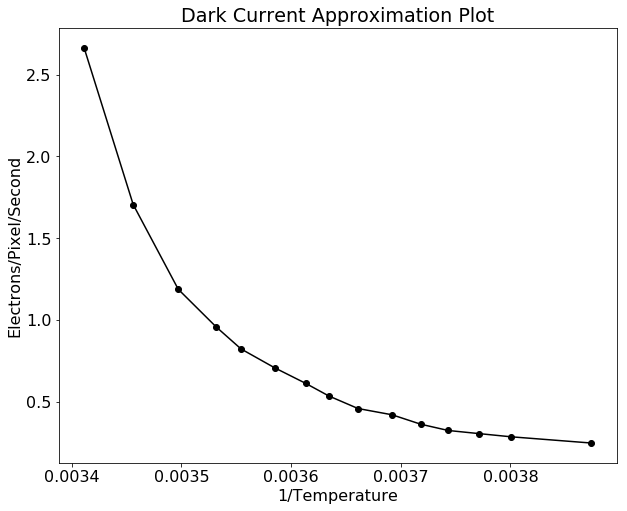

In [200]:
D=electrons_per_sec
T=1/t_kel

plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16

plt.title('Dark Current Approximation Plot')
plt.plot(T, D, '-ko')
plt.xlabel('1/Temperature')
plt.ylabel('Electrons/Pixel/Second')
plt.show()

### And now we are going to fit for band gap energy

In [196]:
# The Boltzmann constant
k_b = 8.6175e-5

def dark_current(t_k, alpha, e_g):
    """
    Analytic expression for dark current as a function of temperature.
    
    Parameters
    ----------
    t_k : numpy.ndarray
        Temperature in Kelvin
    alpha : float
        Constant coefficient in front of exponential funtion.
    e_g : float
        Band gap energy in eV.
    
    Returns
    -------
    dark_current : numpy.ndarray
        Dark current in electrons/pixel/second.
    """
    dark_current = alpha * np.exp(-e_g / (2 * k_b * t_k))
    return dark_current

In [208]:
t_0 = t_kel[-1]
d_0 = electrons_per_sec[-1]

alpha_0 =  d_0 / np.exp(-1.1 / (2 * k_b * t_0))
e_g_0 = 1.1

In [209]:
p_opt, p_cov = curve_fit(dark_current, t_kel, electrons_per_sec, p0=[alpha_0, e_g_0])

# Errors in the fit
sig_alpha, sig_e_g = np.sqrt(np.diag(p_cov))

In [210]:
alpha_fit, e_g_fit = p_opt
print(alpha_fit)
print(e_g_fit)


77098910165.43013
1.2205226843061665


### Here we will plot our values

In [211]:
Dark=dark_current(t_kel, alpha_fit, e_g_fit)
Dark

my_fit1 = np.polyfit(t_kel, Dark,2)
my_fit1
fitted_polynomial = np.poly1d(my_fit1)
fitted_polynomial

poly1d([ 2.46e-03, -1.29e+00,  1.70e+02])

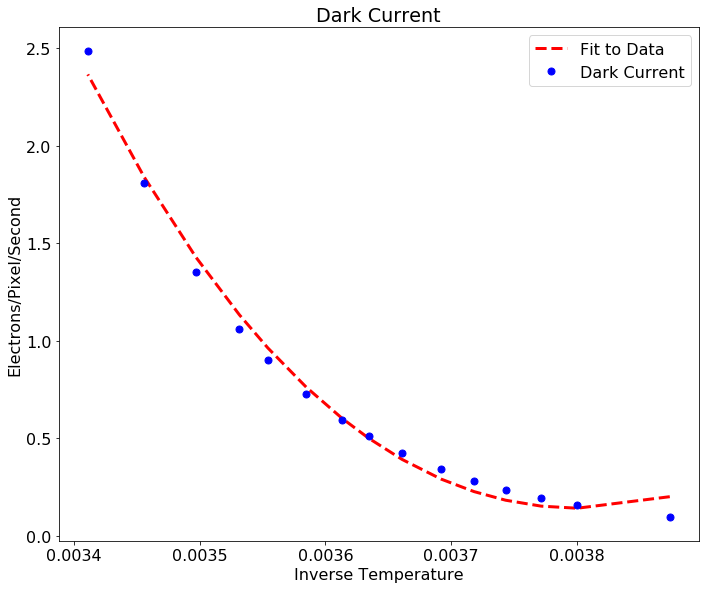

In [212]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(10,8)

fig.tight_layout()

ax.set_title('Dark Current')
ax.set_xlabel("Inverse Temperature")
ax.set_ylabel("Electrons/Pixel/Second")

ax.plot(1/t_kel, fitted_polynomial(t_kel),
        linewidth=3, color='red', linestyle='--',
        label="Fit to Data")

ax.plot(1/t_kel, Dark, color = "b",
        marker="o", linestyle="None", markersize=7,
        label = "Dark Current")

ax.legend(loc=0);

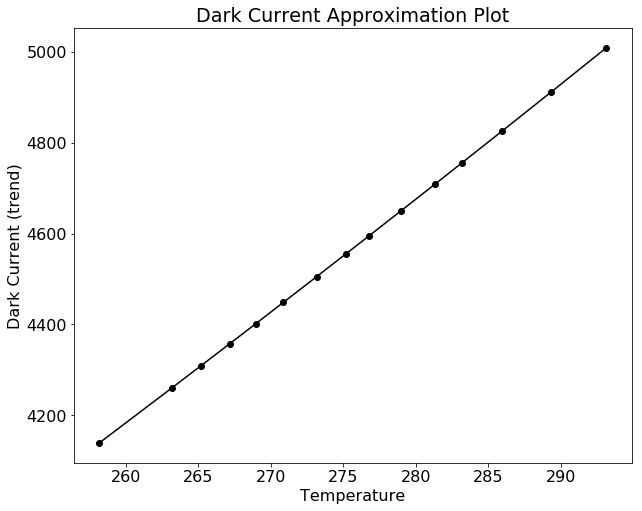

In [194]:
D=(t_kel)**(1.5)*np.exp(-1.1/(2*t_kel))
T=t_kel

plt.figure(figsize=(10, 8))
plt.rcParams['font.size'] = 16

plt.title('Dark Current Approximation Plot')
plt.plot(T, D, '-ko')
plt.xlabel('Temperature')
plt.ylabel('Dark Current (trend)')
plt.show()

### Comparison values table

In [218]:
spec = ['Gain(e/ADU)', 'Read Noise(e/RMS)', 'Dark Current(e/pixel/s @ 0˚C)']
man_spec = ['2.3', '15', '1']
our_spec = ['2.23', '16.6', '0.9']

In [220]:
results = Table([spec, man_spec, our_spec], names=('Aspect', 'Manufacturer Spec.', 'Observed Spec.'))
results

Aspect,Manufacturer Spec.,Observed Spec.
str29,str3,str4
Gain(e/ADU),2.3,2.23
Read Noise(e/RMS),15,16.6
Dark Current(e/pixel/s @ 0˚C),1,0.9
